In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
palette = 'colorblind'
import seaborn as sns; sns.set_palette(palette); sns.set_color_codes(palette)
import numpy as np
from numba import jit

/home/agustina/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Code 6.1

In [ ]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data)
d

#### Code 6.2

In [ ]:
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#### Code 6.3

In [ ]:
1 - m_6_1.resid.var()/d.brain.var()

# m_6_1.summary() check the value for R-squared

#### Code 6.4

In [ ]:
m_6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

#### Code 6.5

In [ ]:
m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

#### Code 6.6

In [ ]:
m_6_7 = smf.ols('brain ~ 1', data=d).fit()

#### Code 6.7

In [ ]:
d_new = d.drop(d.index[-1])

#### Code 6.8

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.scatter(d.mass, d.brain, alpha=0.8)
ax2.scatter(d.mass, d.brain, alpha=0.8)
for i in range(len(d)):
    d_new = d.drop(d.index[-i])
    m0 = smf.ols('brain ~ mass', d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 50)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax1.set_ylabel('body mass (kg)', fontsize=12);
    ax1.set_xlabel('brain volume (cc)', fontsize=12)
    ax1.set_title('Underfit model')
    
    # fifth order model
    m1 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 200)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax2.set_xlim(32,62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel('body mass (kg)', fontsize=12);
    ax2.set_xlabel('brain volume (cc)', fontsize=12)
    ax2.set_title('Overfit model')
plt.show()

#### Code 6.9

In [ ]:
p = (0.3, 0.7)
-sum(p*np.log(p))

#### Code 6.10

In [ ]:
# fit model
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#compute de deviance by cheating
-2 * m_6_1.llf

#### Code 6.11

In [ ]:
# standarize the mass before fitting
d['mass_s'] = d['mass'] - np.mean(d['mass'] / np.std(d['mass']))

with pm.Model() as m_6_8 :
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, np.std(d['brain'])*10)
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    m_6_8 = pm.sample(1000) 

In [ ]:
theta = pm.df_summary(m_6_8)['mean'][:3]

In [ ]:
#compute deviance
dev = -2*sum(stats.norm.logpdf(d['brain'], loc = theta[0] + theta[1]*d['mass_s']  , scale = theta[2]))
dev

#### Code 6.12

In [2]:
from rpy2.robjects.packages import importr

In [3]:
rethinking = importr('rethinking', lib_loc='/home/agustina/R/x86_64-pc-linux-gnu-library/3.2/rethinking')

In [4]:
N = 20
kseq= range(1,6)

In [5]:
step = 10000
r = np.zeros((step, 2))

@jit
def function(k):
    for i in range(step):
        r_ = rethinking.sim_train_test(N=N, k=k)
        r[i, 0] = r_[0]
        r[i, 1] = r_[1]
    return r

In [6]:
dev = np.zeros((4,len(kseq)))
for k in kseq:    
    r = function(k)
    means_sds = [np.mean(r[:,0]), np.mean(r[:,1]), np.std(r[:,0]), np.std(r[:,1])]
    dev[:,k-1] = means_sds

#### Code 6.14

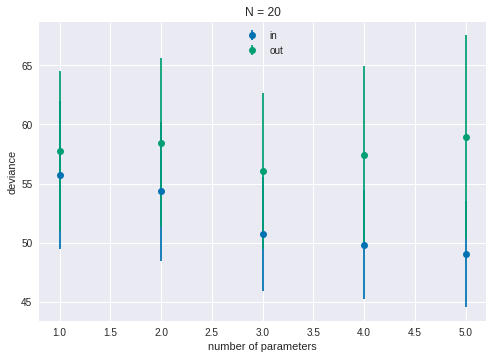

In [8]:
plt.errorbar(x=range(1,6), y=dev[0], yerr=dev[2], fmt='o', label='in')
plt.errorbar(x=range(1,6), y=dev[1], yerr=dev[3], fmt='o', label='out')
plt.xlabel('number of parameters')
plt.ylabel('deviance')
plt.title('N = 20')
plt.legend(loc=9)

#### Code 6.15

In [12]:
data = pd.read_csv('Data/cars.csv', sep=',')

In [13]:
with pm.Model() as m_6_15 :
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, 30)
    mu = pm.Deterministic('mu', a + b * data['speed'])
    dist = pm.Normal('dist', mu=mu, sd=sigma, observed = data['dist'])
    m_6_15 = pm.sample(1000) 

100%|██████████| 1500/1500 [00:05<00:00, 296.07it/s]


In [14]:
n_samples = 1000
n_cases = data.shape[0]
p = np.zeros((n_cases, n_samples))

In [15]:
def function1(n):
    for s in range(0, n):
        mu = m_6_15['a'][s] + m_6_15['b'][s] * data['speed']
        p_ = np.random.normal(loc=mu, scale=m_6_15['sigma'][s], size=None)
        p[:,s] = np.log(p_)
    return p
ll = function1(n_samples)

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))